In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from nn_interpretability.interpretation.lrp.lrp_composite import LRPMix
from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.uncertainty.mc_dropout import MC_Dropout
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

In [2]:
model_name = 'mc_dropout_cnn.pt'

train = False

In [3]:
mnist_data_loader = MnistDataLoader()

In [4]:
model = ModelRepository.get_cnn_dropout(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, mnist_data_loader.trainloader, epochs=30)
    
    ModelRepository.save(model, model_name)

# I. Monte Carlo Dropout
## 1. Test Monte Carlo Dropout
If the number of stochastic forward passes for each observation is big enough (>100 for our case), the accuracy of test set from MC dropout prediction will be close to that from normal prediction.  

In [6]:
ModelTrainer.validate(model, nn.CrossEntropyLoss(), mnist_data_loader.testloader)

Average Test loss: 0.069. Accuracy: 97.95%


In [5]:
MC_Dropout.mc_dropout_validate(model, nn.CrossEntropyLoss(), mnist_data_loader.testloader, 1)
MC_Dropout.mc_dropout_validate(model, nn.CrossEntropyLoss(), mnist_data_loader.testloader, 100)

1 Stochastic forward passes. Average MC Dropout Test loss: 0.304. MC Dropout Accuracy: 91.00%
100 Stochastic forward passes. Average MC Dropout Test loss: 0.069. MC Dropout Accuracy: 97.92%


# II. Uncertainty Example - Rotated Images

/media/storage/dl_env/bdluam-p4-interpretability-of-nn/implementation/nn_interpretability/visualization/mnist_visualizer.py:83: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_stack = np.hstack(image.squeeze(0).cpu().numpy().reshape(28, 28) for image in images)


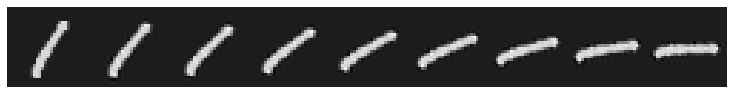

In [5]:
img = mnist_data_loader.get_image_for_class(1).cpu()
rotate_imgs = []
for i in range(0,-63,-7):
    rotate_img = mnist_data_loader.rotate_image(1,i)
    rotate_imgs.append(rotate_img)
    
MnistVisualizer.cat_images(rotate_imgs, 10, 8)

## 1. Prediction without MC dropout

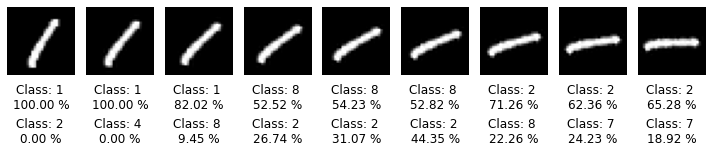

In [8]:
cat_size = torch.Tensor(10,1,28,28)
score, cls = MC_Dropout.predict_class(model, torch.cat(rotate_imgs, out=cat_size), top_k=2)
MnistVisualizer.result_for_each_rotation(rotate_imgs, cls, score, 2, 10, 20)

## 2. MC dropout prediction of the model

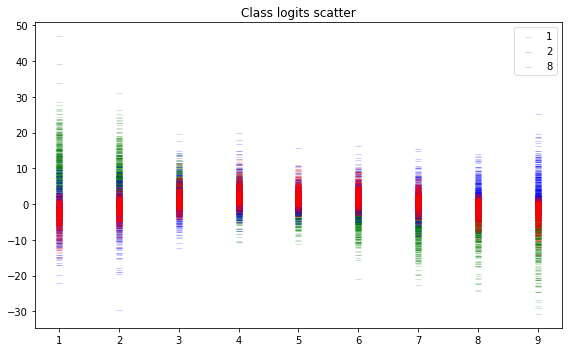

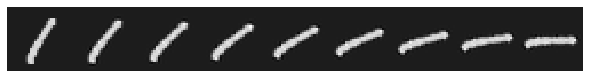

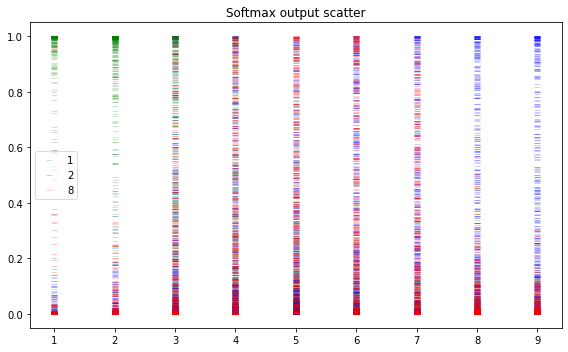

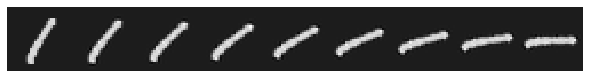

In [7]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)

cls_logits, cls_prob = MC_Dropout.mc_dropout_predict(model, torch.cat(rotate_imgs, out=cat_size), 500)

plt.figure(figsize=(8, 5))
plt.scatter(np.tile(np.arange(1, 10), cls_logits.shape[0]), cls_logits[:, :, 1].flatten(), \
            c='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 10), cls_logits.shape[0]), cls_logits[:, :, 2].flatten(), \
            c='b', marker='_', linewidth=None, alpha=0.2, label='2');
plt.scatter(np.tile(np.arange(1, 10), cls_logits.shape[0]), cls_logits[:, :, 8].flatten(), \
            c='r', marker='_', linewidth=None, alpha=0.2, label='8');
plt.title('Class logits scatter');
plt.legend(framealpha=0.7);
plt.tight_layout();
MnistVisualizer.cat_images(rotate_imgs, 8, 1)


plt.figure(figsize=(8, 5))
plt.scatter(np.tile(np.arange(1, 10), cls_prob.shape[0]), cls_prob[:, :, 1].flatten(), \
            c='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 10), cls_prob.shape[0]), cls_prob[:, :, 2].flatten(), \
            c='b', marker='_', linewidth=None, alpha=0.2, label='2');
plt.scatter(np.tile(np.arange(1, 10), cls_prob.shape[0]), cls_prob[:, :, 8].flatten(), \
            c='r', marker='_', linewidth=None, alpha=0.2, label='8');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);
plt.tight_layout();
MnistVisualizer.cat_images(rotate_imgs, 8, 1)

## 3. Use LRP to interpret uncertainty
Check out how we use our **nn_interpretability** API by just calling `LRPMix()` and `interpretor.interpret()` two lines
### 3.1 Interpret with composite LRP
We first observe 1000 predictions. For each prediction we perform LRP backward pass to the bottom layer starting from the **predicted class**. If the predicted classes are the same in our observation, their corresponding heatmaps will sum together. From the following images we see that LRP fails to tell us the uncertainty of the model's predictions.

In [9]:
import torch.nn.functional as F
from nn_interpretability.interpretation.lrp.lrp_ab import LRPAlphaBeta
from nn_interpretability.interpretation.lrp.lrp_composite import LRPMix
import matplotlib.pyplot as plt

def uncertain_prediction_lrp_mix(model, image, T=1000):
    model.train()
    endpoint = torch.zeros_like(image[0], device=MC_Dropout.device).repeat(10,1,1,1)
    image = image.to(MC_Dropout.device)
    times = torch.zeros(10)
    for _ in range(T):
        # Consturct LRPMix
        interpretor = LRPMix(model, 'predicted', None, 1, 0, 0)
        heatmap = interpretor.interpret(image)
        predicted = interpretor.get_class()
        endpoint[predicted] += heatmap[0]
        times[predicted] += 1
    return endpoint.detach().cpu().numpy(), times


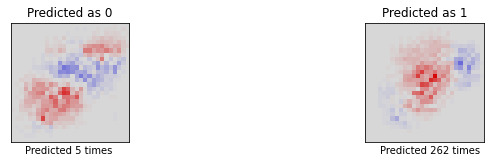

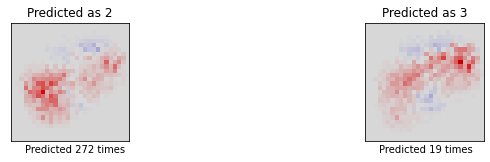

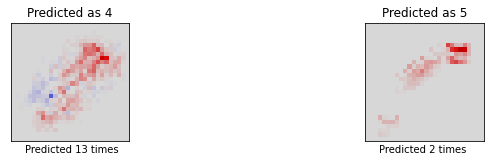

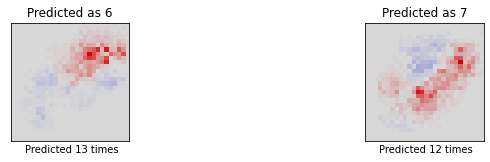

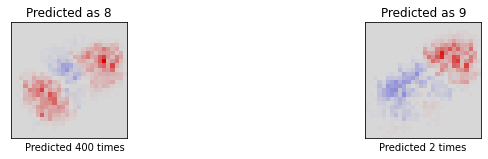

In [10]:
out, predict_times = uncertain_prediction_lrp_mix(model, rotate_imgs[3], 1000)
MnistVisualizer.dropout_heatmap_for_each_class(out, predict_times)

Another approach is to observe 1000 times predictions for each class. Different from the above method, this time we perform LRP backward pass starting from an **assigned class**. We sum the resulting heatmaps from all these 1000 predictions even if the predicted class is not same as the assigned class. This approach shows that for the classes that our model is tend to predict, the resulting heatmap will contain more red pixels. In other words, the more heatmaps consisting mainly of red pixels we have, the more uncertain our prediction is.

In [16]:
def uncertain_all_lrp_mix(model, image, T=1000):
    model.train()
    endpoint = torch.zeros_like(image[0], device=MC_Dropout.device).repeat(10,1,1,1)
    image = image.to(MC_Dropout.device)
    times = torch.zeros(10)
    for _ in range(T):
        for i in range(10):
            # Consturct LRPMix
            interpretor = LRPMix(model, i, None, 1, 0, 0)
            heatmap = interpretor.interpret(image)
            predicted = interpretor.get_class()
            endpoint[i] += heatmap[0]
            if predicted == i: times[i] += 1 
    return endpoint.detach().cpu().numpy(), times

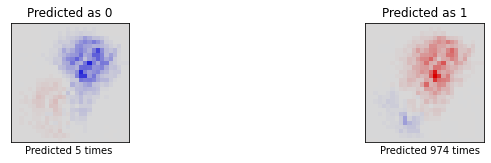

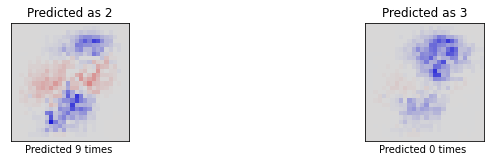

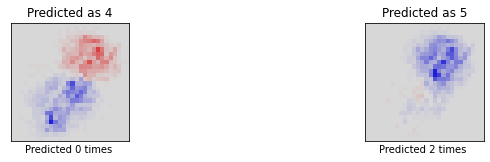

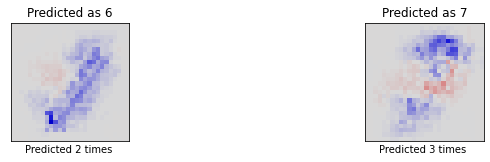

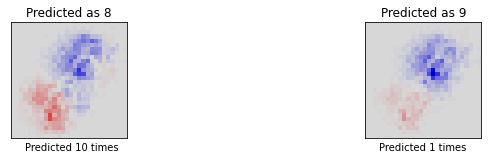

In [17]:
out, predict_times = uncertain_all_lrp_mix(model, rotate_imgs[1], 1000)
MnistVisualizer.dropout_heatmap_for_each_class(out, predict_times)

### 3.2 Interpret with  LRP-α1β0 (Deep Taylor Decomposition)

In [13]:
from nn_interpretability.interpretation.lrp.lrp_ab import LRPAlphaBeta

def uncertain_all_lrp_ab(model, image, T=1000):
    model.train()
    endpoint = torch.zeros_like(image[0], device=MC_Dropout.device).repeat(10,1,1,1)
    image = image.to(MC_Dropout.device)
    times = torch.zeros(10)
    for _ in range(T):
        for i in range(10):
            # Consturct LRPMix
            interpretor = LRPAlphaBeta(model, i, None, 1, 0, 0)
            heatmap = interpretor.interpret(image)
            predicted = interpretor.get_class()
            endpoint[i] += heatmap[0]
            if predicted == i: times[i] += 1 
    return endpoint.detach().cpu().numpy(), times

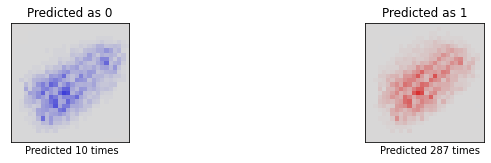

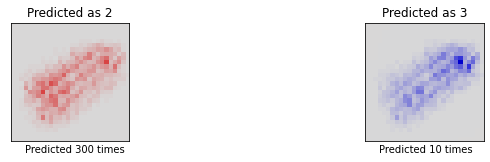

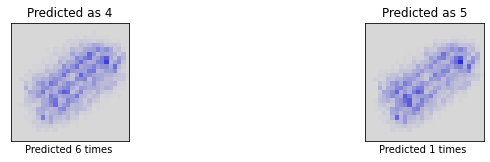

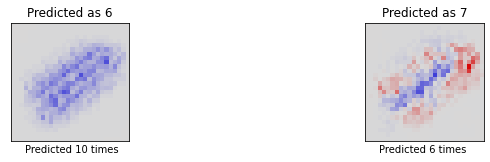

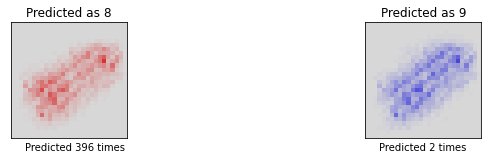

In [14]:
out, predict_times = uncertain_all_lrp_ab(model, rotate_imgs[3], 1000)
MnistVisualizer.dropout_heatmap_for_each_class(out, predict_times)

### 3.3 Interpret with  DeepLIFT RevealCancel

Now we try to introduce uncertainty to the `DeepLIFT` method and more specifically, the `RevealCancel` rule. In order to do so, we are going to choose an image and execute `DeepLIFT` 1000 times for it. In each iteration, we are adding random noise to the image. If the image was classified for the class C, we are adding the result to the collection of results which are classified for the class C. At the end, we are displaying the composite result for each class. Deep blue image refers to classes for which no classifications have occurred.

In [18]:
from nn_interpretability.interpretation.deeplift.deeplift import DeepLIFT, DeepLIFTRules

def uncertain_all_deeplift(model, image, T=1000):
    model.train()
    interpretor = DeepLIFT(model, i, None, DeepLIFTRules.RevealCancel)
    
    device = MC_Dropout.device
    endpoint = torch.zeros_like(image[0]).repeat(10,1,1,1).to(device)
    image = image.to(device)
    times = torch.zeros(10)
    
    for j in range(T):
        noisy_img = img + torch.randn(img.size()) * 0.08
        result = interpretor.interpret(noisy_img)
        predicted = interpretor.last_prediction()
        
        endpoint[predicted] += result[0]
        times[predicted] += 1
        
    return endpoint.detach().cpu().numpy(), times

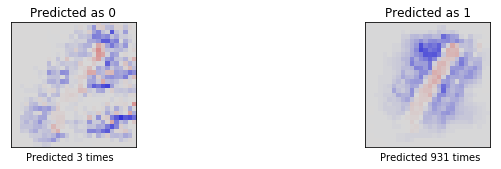

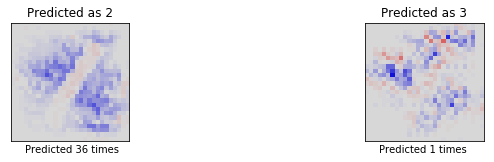

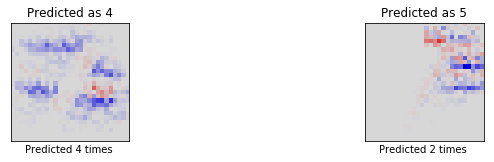

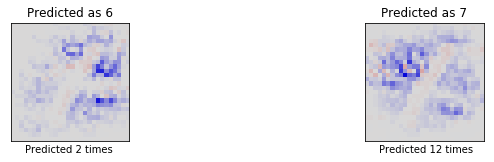

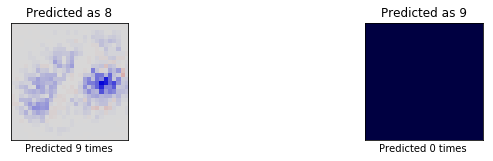

In [22]:
img = mnist_data_loader.get_image_for_class(1)
out, predict_times = uncertain_all_deeplift(model, img, 1000)
MnistVisualizer.dropout_heatmap_for_each_class(out, predict_times)